In [149]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime

#Statistics
# Statistics
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from dateutil.parser import parse 
import pickle

# READ CSV AND DESCRIPTION OF SERIES


In [111]:
#MARKET PRICE
market_price = pd.read_csv("data/market-price.csv")

market_price['Timestamp'] = market_price['Timestamp'].str.split(' ').str[0]
market_price["Timestamp"] = pd.to_datetime(market_price["Timestamp"])
market_price = market_price.rename(columns={'market-price': 'Price'})

#Description
print(market_price.head())
print("\nShape is:", market_price.shape)
print("\nSummary of the dataset:")
market_price.describe()
print("\nAre there null values?")
market_price.isna().sum()

   Timestamp  Price
0 2009-01-02    0.0
1 2009-01-05    0.0
2 2009-01-08    0.0
3 2009-01-11    0.0
4 2009-01-14    0.0

Shape is: (1665, 2)

Summary of the dataset:

Are there null values?


Timestamp    0
Price        0
dtype: int64

Due to leap years (bisestili) and to the fact that 365 is not divisible for 3, some years only have 121 prices while the majority has 122. We give the possibility to add one fake price at the beginning of those years, the fake price is given to the date yyyy-01-01 as the mean of the last price of the previous year and the first price of the year. The price is added at the beginning of the year because when we'll need to move to monthly prices we'll use the last price of each month and if we add the fake price at the end of the year we will "dirty" december monthly price. 

For the same reason while creating shorter time series (below) we exclude year 2022 from the analysis because we have only about 90 prices which is a lot less than 122.

In [112]:
rendi_equo = True # mettere a false se non lo si vuole fare
if rendi_equo:
    agg = pd.DataFrame([[pd.to_datetime('2014-01-01'),769.96],
                        [pd.to_datetime('2018-01-01'),14417.62],
                        [pd.to_datetime('2010-01-01'),0.00]], columns = ['Timestamp','Price'])
    market_price = pd.concat([market_price,agg]).sort_values('Timestamp',ignore_index=True)

# VISUALIZATION

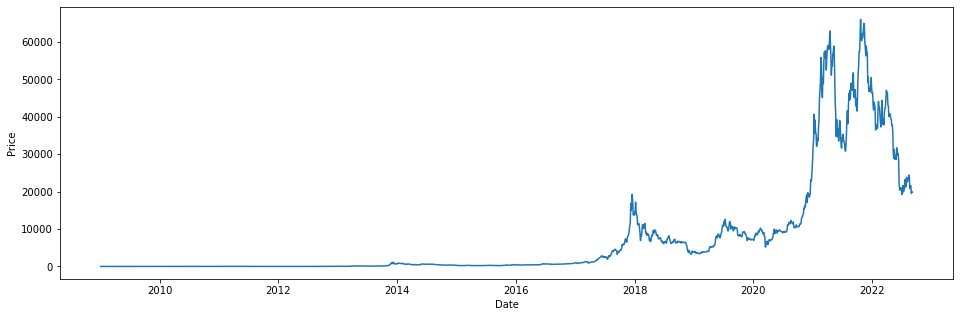

In [113]:
plt.figure(figsize=(16,5))
plt.plot(market_price["Timestamp"], market_price["Price"])
plt.gca().set(xlabel="Date", ylabel="Price")
#scommentare riga giù per visualizzare in scala log
#plt.yscale('log') 
plt.show()

#### Check distribution of the time series

What distribution the data follows?

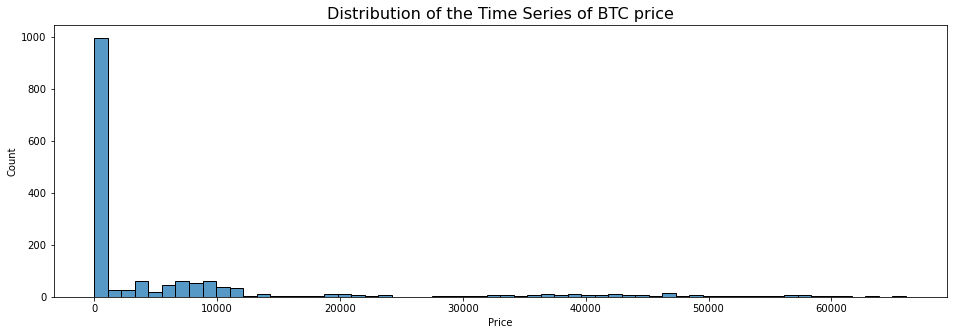

In [114]:
plt.figure(figsize=(16,5))
sns.histplot(market_price["Price"], kde = False, bins = 60)
plt.title('Distribution of the Time Series of BTC price', fontsize=16)
plt.show()

#### Shorter time series

The time series is null (or almost null) in many days. We can create different time series extracting only smaller intervals of time. In particular we define:
1. mpriceh, market price high, where the time series where values are considerably higher than 0, 2017-2021
2. mpricen, market place normal, where the time series where values are higher than zero and not extreme, 2017-2020
3. mpricenh, market price normal high, where the yearly mean value is greater than 100 and values are not extreme, 2013-2020
4. mpricef, market price full, years where the mean value is greater than 100, 2013-2021

In [115]:
market_price["Price"][market_price["Timestamp"].dt.year == 2014].mean()
mpriceh = market_price.loc[(market_price["Timestamp"].dt.year > 2016) & (market_price["Timestamp"].dt.year < 2022),:]
mpricen = market_price.loc[(market_price["Timestamp"].dt.year > 2016) & (market_price["Timestamp"].dt.year < 2021),:]
mpricenh = market_price.loc[(market_price["Timestamp"].dt.year > 2012) & (market_price["Timestamp"].dt.year < 2021),:]
mpricef = market_price.loc[(market_price["Timestamp"].dt.year > 2012) & (market_price["Timestamp"].dt.year < 2022),:]

<AxesSubplot:xlabel='Price', ylabel='Count'>

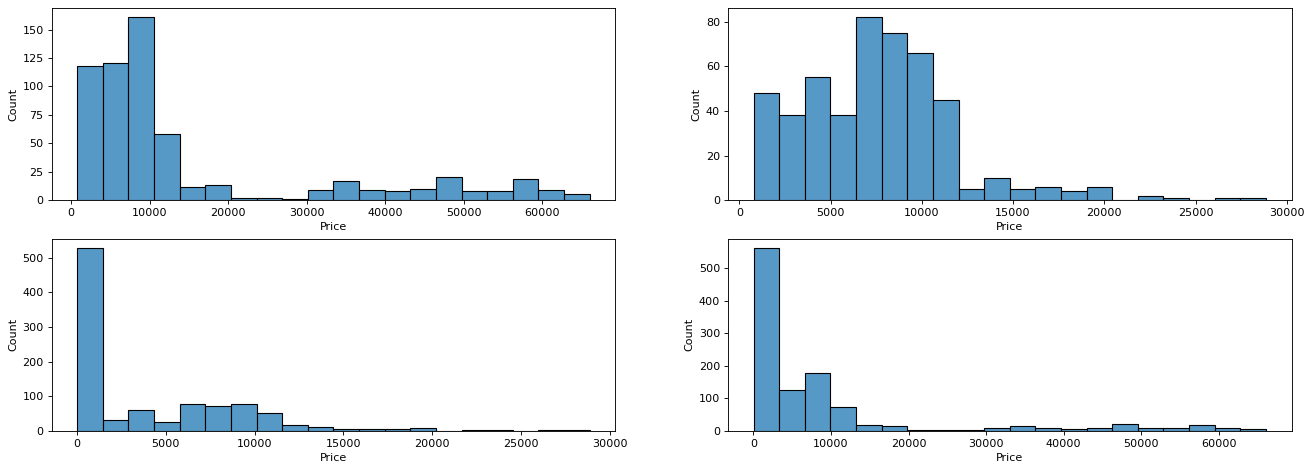

In [116]:
fig, axes = plt.subplots(2, 2, figsize=(20,7), dpi= 80)
sns.histplot(mpriceh["Price"], ax=axes[0,0],bins = 20)
sns.histplot(mpricen["Price"], ax=axes[0,1],bins = 20)
sns.histplot(mpricenh["Price"], ax=axes[1,0],bins = 20)
sns.histplot(mpricef["Price"], ax=axes[1,1],bins = 20)

There are still a lot of prices close to 0 but all the new time series have many tall bins.

#### Checking monthly seasonality using multiple lines
Price follows a certain repetitive pattern every year? 

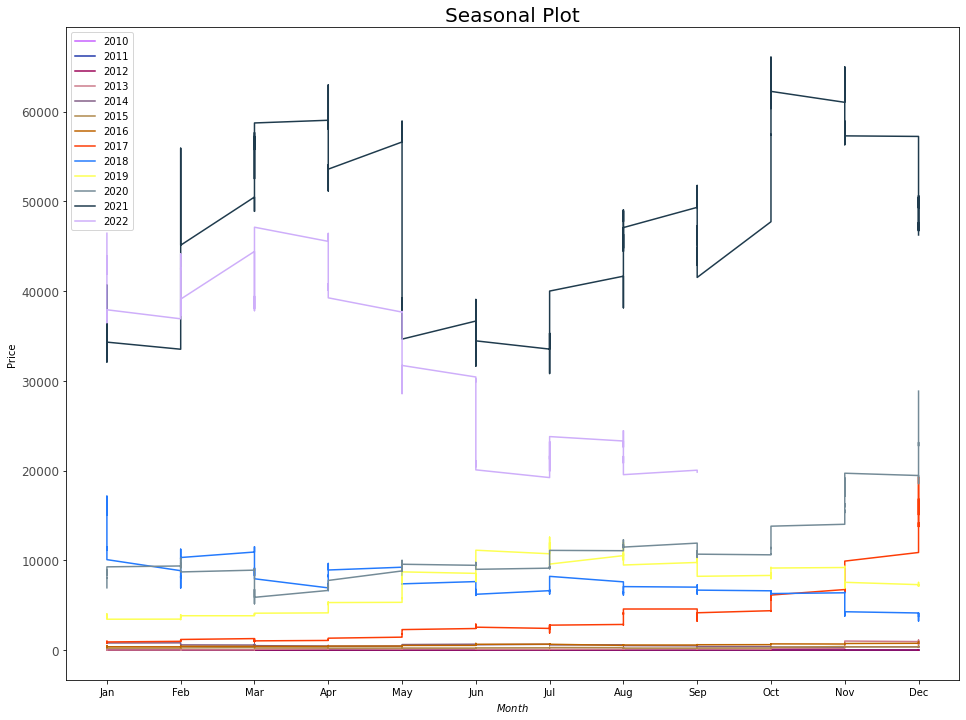

In [7]:
# Prepare data
market_price['year'] = [d.year for d in market_price["Timestamp"]]
market_price['month'] = [d.strftime('%b') for d in market_price["Timestamp"]]
years = market_price['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(matplotlib.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,12))
for i, y in enumerate(years):
    if i > 0:
        plt.plot('month', "Price", data=market_price.loc[market_price.year==y, :], color=mycolors[i], label=y)
        #plt.text(market_price.loc[market_price.year==y, :].shape[0]-.9, market_price.loc[market_price.year==y, "Price"][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(ylabel= "Price", xlabel = '$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot", fontsize=20)
plt.legend(['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022'], loc='upper left')
plt.show()

#### Checking trend using boxplot
Price follows a yearly trend or monthly seasonality? 

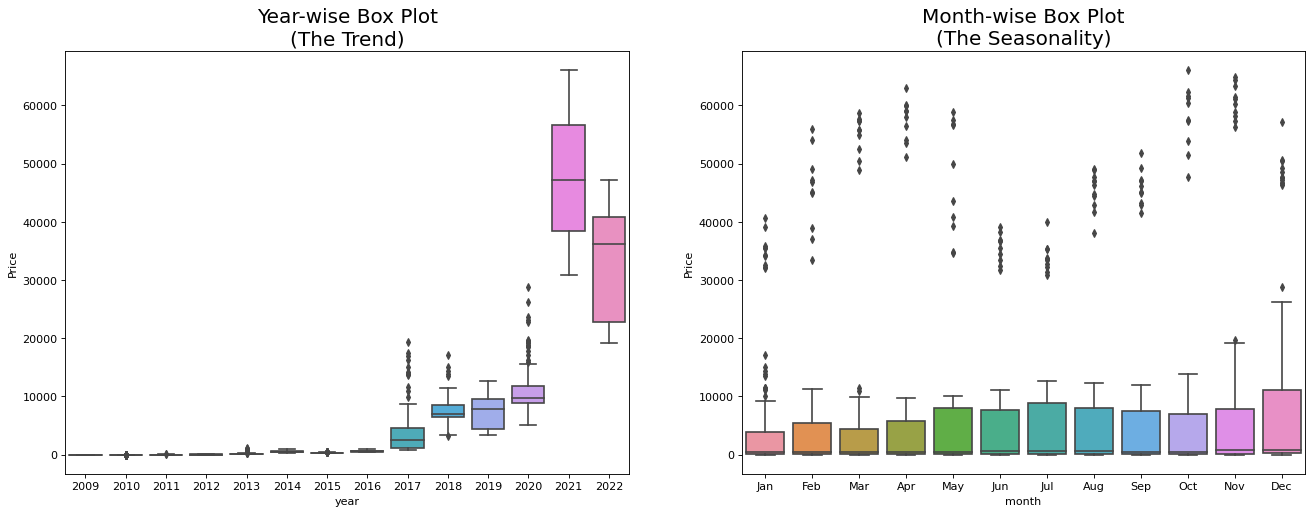

In [29]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y="Price", data=market_price, ax=axes[0])
sns.boxplot(x='month', y="Price", data=market_price.loc[~market_price.year.isin([2010, 2022]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

# Time series decomposition
Additive or multiplicative


La decomposizione moltiplicativa per adesso da un errore (a causa di valori 0/negativi o troppo piccoli suppongo)

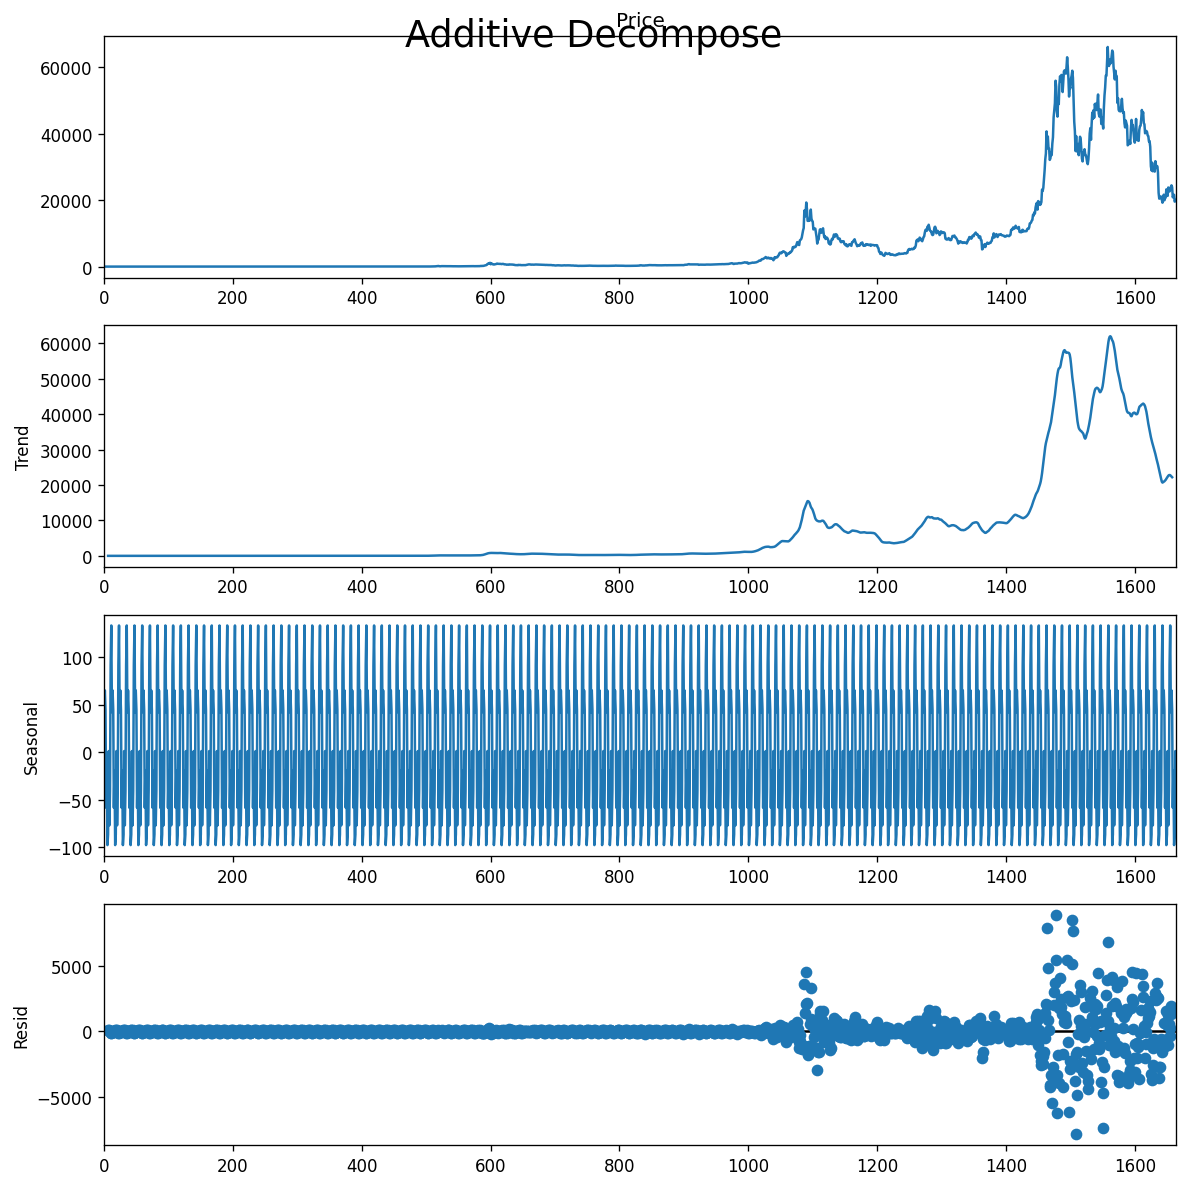

In [34]:
input_seasonality = 12
# Multiplicative Decomposition 
#result_mul = seasonal_decompose(market_price["Price"], model='multiplicative', period=input_seasonality)

# Additive Decomposition
result_add = seasonal_decompose(market_price["Price"], model='additive', period=input_seasonality)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
#result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [35]:
# Extract the Components ----
# Actual Values = Summation of (Seasonal + Trend + Resid)
df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head(10)

,seas,trend,resid,actual_values
0,42.199919,NaN,NaN,0.0
1,65.124294,NaN,NaN,0.0
2,44.656353,NaN,NaN,0.0
3,-58.246651,NaN,NaN,0.0
4,-18.831991,NaN,NaN,0.0
5,-97.527439,NaN,NaN,0.0
6,-86.362488,0.0,86.362488,0.0
7,1.334393,0.0,-1.334393,0.0
8,-76.762895,0.0,76.762895,0.0
9,-40.623424,0.0,40.623424,0.0


### Seasonal decomposition using STL

I don't know if STL function has the possibility of using a multiplicative model, probably for that one we must stick to seasonal_decompose

In [132]:
# we should try on all the new t.s.
res1 = STL(mpricef["Price"], period = 122, robust = True).fit()
res2 = STL(mpricef["Price"], period = 122).fit()

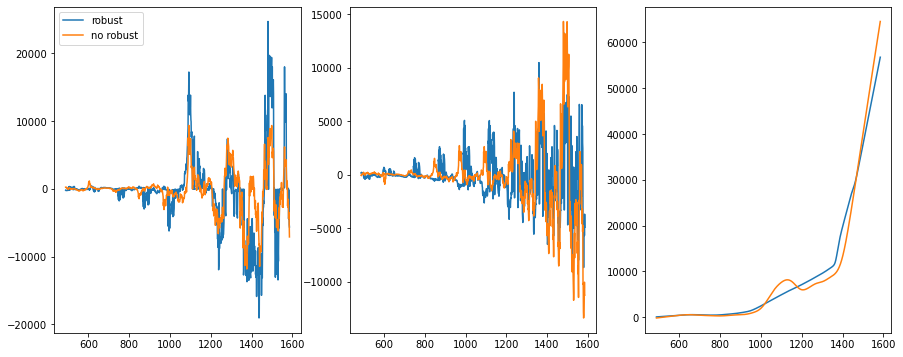

In [141]:
fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res1.resid, label="robust")
axs[0].plot(res2.resid, label="no robust")
axs[0].legend()
axs[1].plot(res1.seasonal)
axs[1].plot(res2.seasonal)
axs[2].plot(res1.trend)
axs[2].plot(res2.trend)

Repeating the decomposition with the robust option yields a flatter trend and a bit higher seasonal and residual values, which one should we prefer? 
a) If we are interested in fitting the trend probebly the robust one because it is more smooth and grows a bit less rapidly, especially at the very end.
b) Since btr price is very volatile and often perturbed by speculations it may make more sense to think that it has a smooth trend and strong variations than a more volatile trend and smaller variations.
I would then prefer the robust one...

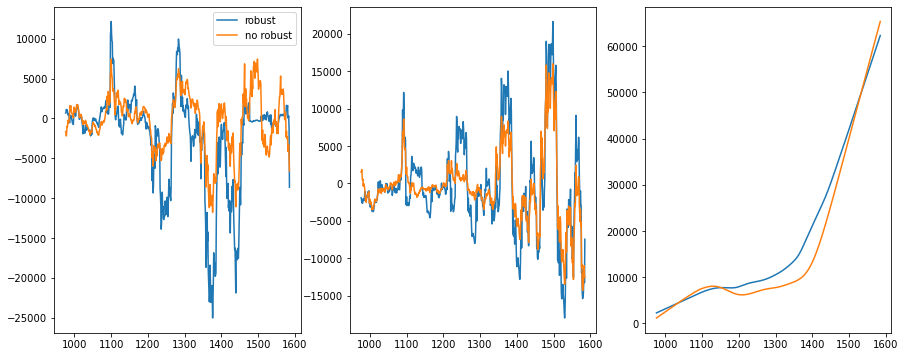

In [145]:
res3 = STL(mpriceh["Price"], period = 122, robust = True).fit()
res4 = STL(mpriceh["Price"], period = 122).fit()
fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res3.resid, label="robust")
axs[0].plot(res4.resid, label="no robust")
axs[0].legend()
axs[1].plot(res3.seasonal)
axs[1].plot(res4.seasonal)
axs[2].plot(res3.trend)
axs[2].plot(res4.trend)

Same considerations as above.

#### Trend interpolation
We now try to interploate the trend with an exponential function.

In [170]:
# y = a*exp(bx) --> log(y) = log(a)+bx
coefs = np.polyfit(np.arange(610)+1, np.log(res3.trend),1) # o np.polyfit(np.arange(610)+1,np.log(res3.trend),1,w=numpy.sqrt(y))
coefs
# y = exp(coefs[1])*exp(coefs[0]*x)

array([4.78405874e-03, 7.98339040e+00])

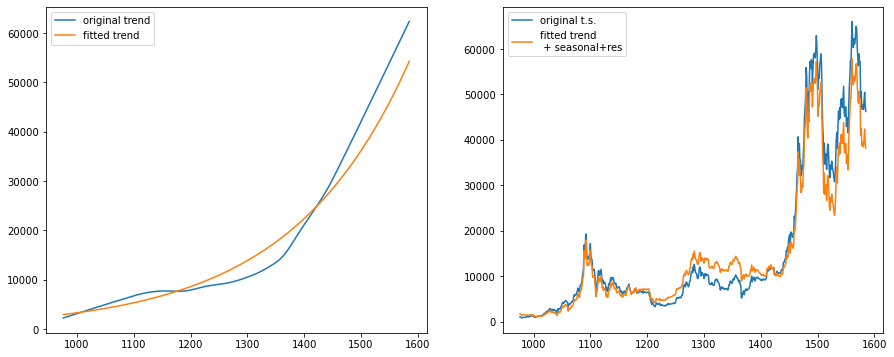

In [182]:
fitted = pd.Series(np.exp(coefs[1])*np.exp(coefs[0]*(np.arange(610)+1)), index = mpriceh.index)
#fitted.plot()
#res3.trend.plot()


fitted_season = fitted+res3.seasonal # fitted trend + seasonal decomposed series (orange) non so se ha senso calcolarlo
fitted_compl = fitted_season+res3.resid # fitted trend + seasonal decomposed series + residual decomposed series (green)
#mpriceh["Price"].plot()
#fitted_season.plot()
#fitted_compl.plot()


fig, axs = plt.subplots(ncols=2, figsize=(15,6))
axs[0].plot(res3.trend, label="original trend")
axs[0].plot(fitted, label="fitted trend")
axs[0].legend()
axs[1].plot(mpriceh["Price"], label='original t.s.')
#axs[1].plot(fitted_season, label='fitted trend\n + seasonal')
axs[1].plot(fitted_compl, label='fitted trend\n + seasonal+res')
axs[1].legend()

The right graph, given by trend interpolation plus the residual and the seasonal decomposed time series, is a good approximation of the real time series.

### Multiplicative model

DA FARE E CONTROLLARE

In [126]:
results = seasonal_decompose(mpricef["Price"], model='multiplicative', period=122)

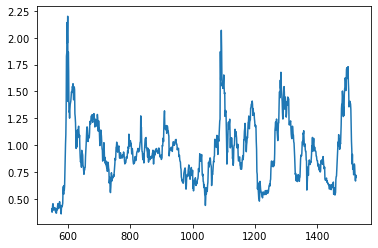

In [129]:
results.resid.plot()
plt.show()

In [183]:
def monthly_prices(prezzi):
    '''Converte i prezzi da daily a monthly)'''
    df = prezzi.set_index('Timestamp').copy()
    old_index = df.index
    df = df.resample('M').last()
    new_index = []
    for i in df.index:
        new_index.append(old_index[old_index <= i].max())
    df.index = new_index
    return df

# monthly_prices(mpricen)

# Stationarity Test - Augmented Dickey Fuller test (ADH Test)

ADH: null hypothesis is the time series possesses a unit root and is non-stationary. So, if the P-Value in ADH test is less than the significance level (0.05), you reject the null hypothesis.

In [36]:
# ADF Test
result = adfuller(market_price["Price"].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.9284944209705024
p-value: 0.3187774231417213
Critial Values:
   1%, -3.434346077596202
Critial Values:
   5%, -2.8633050385525523
Critial Values:
   10%, -2.567709666778468


# ACF-PACF plots and order of differencing

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


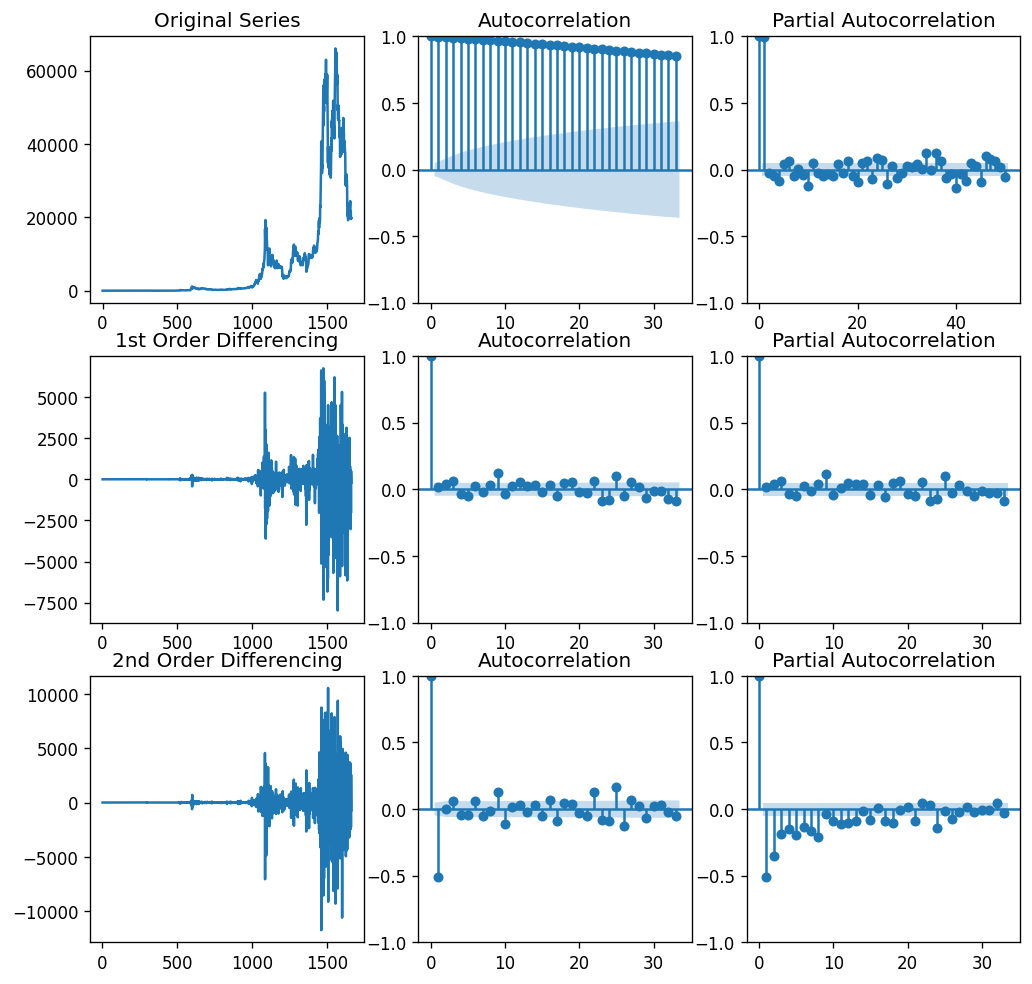

In [37]:
# Original Series
fig, axes = plt.subplots(3, 3)
axes[0, 0].plot(market_price["Price"]); axes[0, 0].set_title('Original Series')
plot_acf(market_price["Price"], ax=axes[0, 1])
plot_pacf(market_price["Price"], lags=50, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(market_price["Price"].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(market_price["Price"].diff().dropna(), ax=axes[1, 1])
plot_pacf(market_price["Price"].diff().dropna(), ax=axes[1, 2])


# 2nd Differencing
axes[2, 0].plot(market_price["Price"].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(market_price["Price"].diff().diff().dropna(), ax=axes[2, 1])
plot_pacf(market_price["Price"].diff().diff().dropna(), ax=axes[2, 2])

plt.show()

In [38]:
# ADF Test for 2 order of differencing
result = adfuller(market_price["Price"].diff().diff().dropna().values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -12.909656889159496
p-value: 4.082389873627737e-24
Critial Values:
   1%, -3.434350967480226
Critial Values:
   5%, -2.8633071969335333
Critial Values:
   10%, -2.56771081609273
